This tutorial takes reference from https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/ and https://www.tensorflow.org/tutorials/images/segmentation

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# load data from TFDS
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [4]:
print(dataset['train'])

<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [5]:
# resize image to smaller size to speed up training
def resize(input_image, input_mask):
  input_image = tf.image.resize(input_image, (128, 128), method="nearest")
  input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

  return input_image, input_mask

In [6]:
# randomly augment images to prevent overfitting
def augment(input_image, input_mask):
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask

In [7]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1

  return input_image, input_mask

In [8]:
def load_image_train(datapoint):
  input_image = datapoint["image"]
  input_mask = datapoint["segmentation_mask"]
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = augment(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [9]:
def load_image_test(datapoint):
  input_image = datapoint["image"]
  input_mask = datapoint["segmentation_mask"]
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [10]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

# TODO: what is tf.data.AUTOTUNE? -> for tf.data to use CPU efficiently

In [11]:
# NOTE: image has 3 channels whereas segment as 1
print(train_dataset)

<ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>


In [12]:
# prepare training, validationa nd test batches
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [13]:
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [14]:
# visualise data

def display(display_list):
  plt.figure(figsize=(15,15))
  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i + 1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

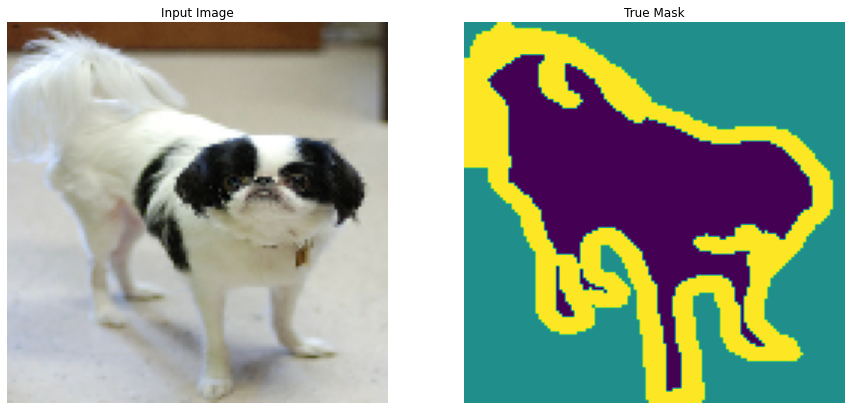

In [15]:
sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])


In [16]:
# U-Net building block

def double_conv_block(x, n_filters):

  x = layers.Conv2D(n_filters, 3, padding="same", activation = "relu", kernel_initializer = "he_normal")(x)
  x = layers.Conv2D(n_filters, 3, padding="same", activation = "relu", kernel_initializer = "he_normal")(x)

  return x

# TODO: why he_normal? -> works better wirth Relu

In [17]:
def downsample_block(x, n_filters):
  f = double_conv_block(x, n_filters)
  p = layers.MaxPool2D(2)(f)
  p = layers.Dropout(0.3)(p)

  return f, p

In [18]:
def upsample_block(x, conv_features, n_filters):
  # upsample
  x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
  # concatenate
  x = layers.concatenate([x, conv_features])
  # dropout
  x = layers.Dropout(0.3)(x)
  # Conv2D + ReLU
  x = double_conv_block(x, n_filters)

  return x

In [19]:
# build U-Net

def build_unet_model():

  # input
  inputs = layers.Input(shape=(128, 128, 3))

  # encoder
  f1, p1 = downsample_block(inputs, 64)
  f2, p2 = downsample_block(p1, 128)
  f3, p3 = downsample_block(p2, 256)
  f4, p4 = downsample_block(p3, 512)

  # bottleneck
  bottleneck = double_conv_block(p4, 1024)

  # decoder
  u6 = upsample_block(bottleneck, f4, 512)
  u7 = upsample_block(u6, f3, 256)
  u8 = upsample_block(u7, f2, 128)
  u9 = upsample_block(u8, f1, 64) 

  # output
  outputs = layers.Conv2D(3,1,padding="same", activation= "softmax")(u9)

  unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

  return unet_model

In [20]:
unet_model = build_unet_model()

In [21]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

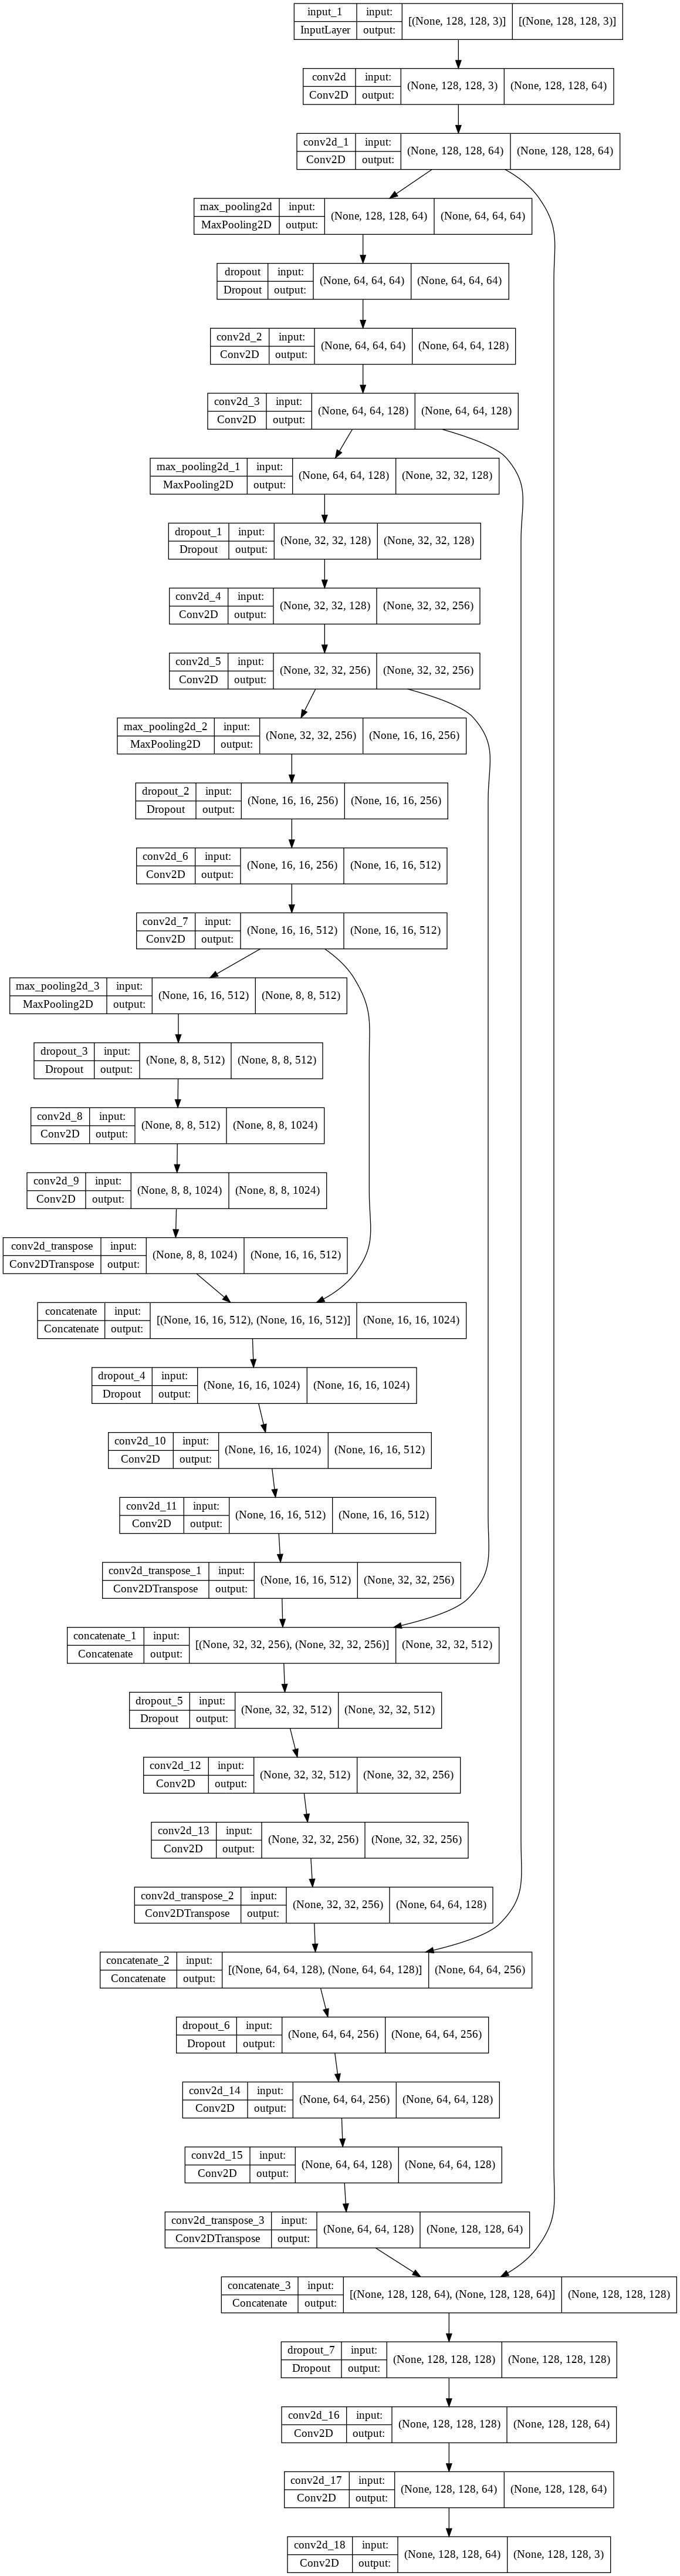

In [22]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [23]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                   loss="sparse_categorical_crossentropy", 
                   metrics="accuracy")

In [24]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5

TEST_LENGTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

timeBegin = time.time()

model_history = unet_model.fit(train_batches, 
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS, 
                               validation_data=validation_batches)

print("Total time processed {:.2f}".format(time.time()-timeBegin))

Epoch 1/20
57/57 [==============================] - 69s 907ms/step - loss: 0.8477 - accuracy: 0.6419 - val_loss: 0.7075 - val_accuracy: 0.7218
Epoch 2/20
57/57 [==============================] - 61s 946ms/step - loss: 0.6484 - accuracy: 0.7388 - val_loss: 0.6067 - val_accuracy: 0.7551
Epoch 3/20
57/57 [==============================] - 54s 946ms/step - loss: 0.5829 - accuracy: 0.7684 - val_loss: 0.5268 - val_accuracy: 0.7956
Epoch 4/20
57/57 [==============================] - 54s 947ms/step - loss: 0.5162 - accuracy: 0.7977 - val_loss: 0.5233 - val_accuracy: 0.7905
Epoch 5/20
57/57 [==============================] - 54s 944ms/step - loss: 0.4775 - accuracy: 0.8142 - val_loss: 0.4376 - val_accuracy: 0.8334
Epoch 6/20
57/57 [==============================] - 54s 946ms/step - loss: 0.4576 - accuracy: 0.8239 - val_loss: 0.4511 - val_accuracy: 0.8258
Epoch 7/20
57/57 [==============================] - 54s 947ms/step - loss: 0.4166 - accuracy: 0.8391 - val_loss: 0.3964 - val_accuracy: 0.8466

In [25]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

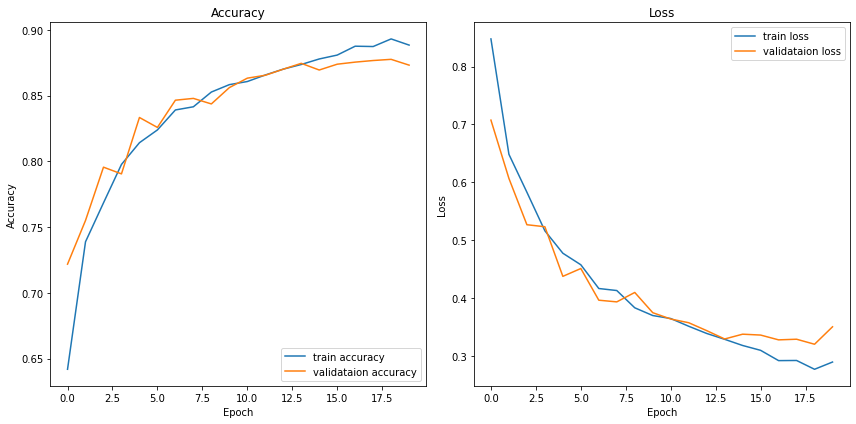

In [26]:
display_learning_curves(unet_model.history)

In [27]:
# prediction

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

# TODO: what does ... mean? -> take all values in that axis
# TODO: how do we map all the pixels in the image into numbers? -> the last 
# output layer has a filter size of 3, which represents 3 possible values. 
# When colour coding it in plt, use tensor_to_img function to visualise

In [28]:
def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [29]:
count = 0
for i in test_batches:
  count += 1 
print("number of batches:", count)

number of batches: 11


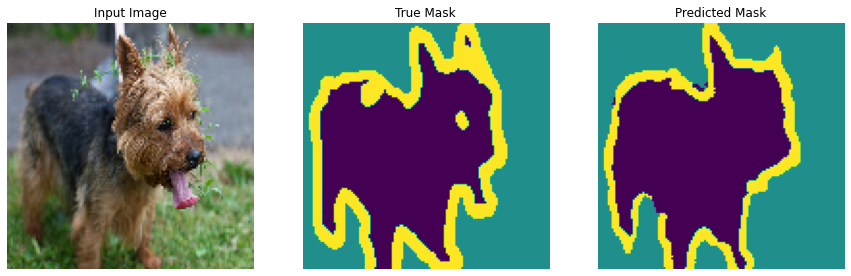

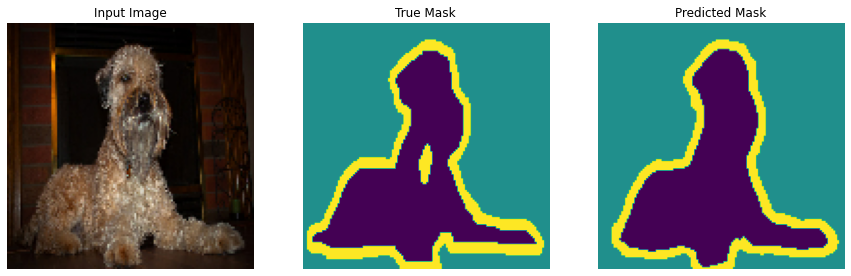

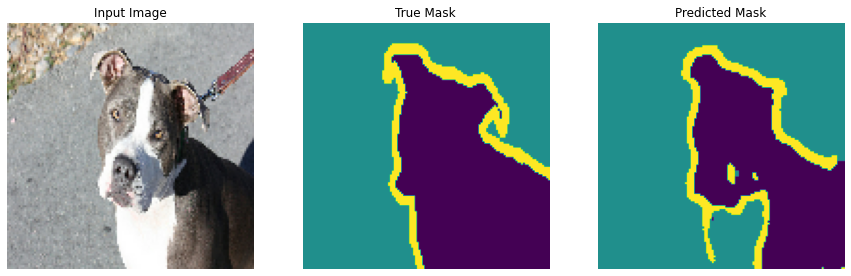

In [30]:
show_predictions(unet_model, test_batches.skip(5), 3)

In [31]:
# using transfer learning to increase speed and accuracy (refer to https://www.tensorflow.org/tutorials/images/segmentation)

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# freeze
down_stack.trainable = False

In [32]:
def build_tl_unet_model():

  # input
  inputs = layers.Input(shape=(128, 128, 3))

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  

  # bottleneck
  bottleneck = double_conv_block(x, 1024)

  # decoder
  u6 = upsample_block(bottleneck, skips[3], 512)
  u7 = upsample_block(u6, skips[2], 256)
  u8 = upsample_block(u7, skips[1], 128)
  u9 = upsample_block(u8, skips[0], 64) 

  # last layer
  outputs = layers.Conv2DTranspose(filters=3,kernel_size=3,strides=2, padding="same", activation= "softmax")(u9)
  # NOTE: since there are 3 outputs, we will have a filter size of 3, each represents 1 of the classes in that pixel

  unet_model = tf.keras.Model(inputs, outputs, name="Transfer-Learning-U-Net")

  return unet_model


In [33]:
tl_unet_model = build_tl_unet_model()

In [34]:
tl_unet_model.summary()

Model: "Transfer-Learning-U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['input_3[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                          

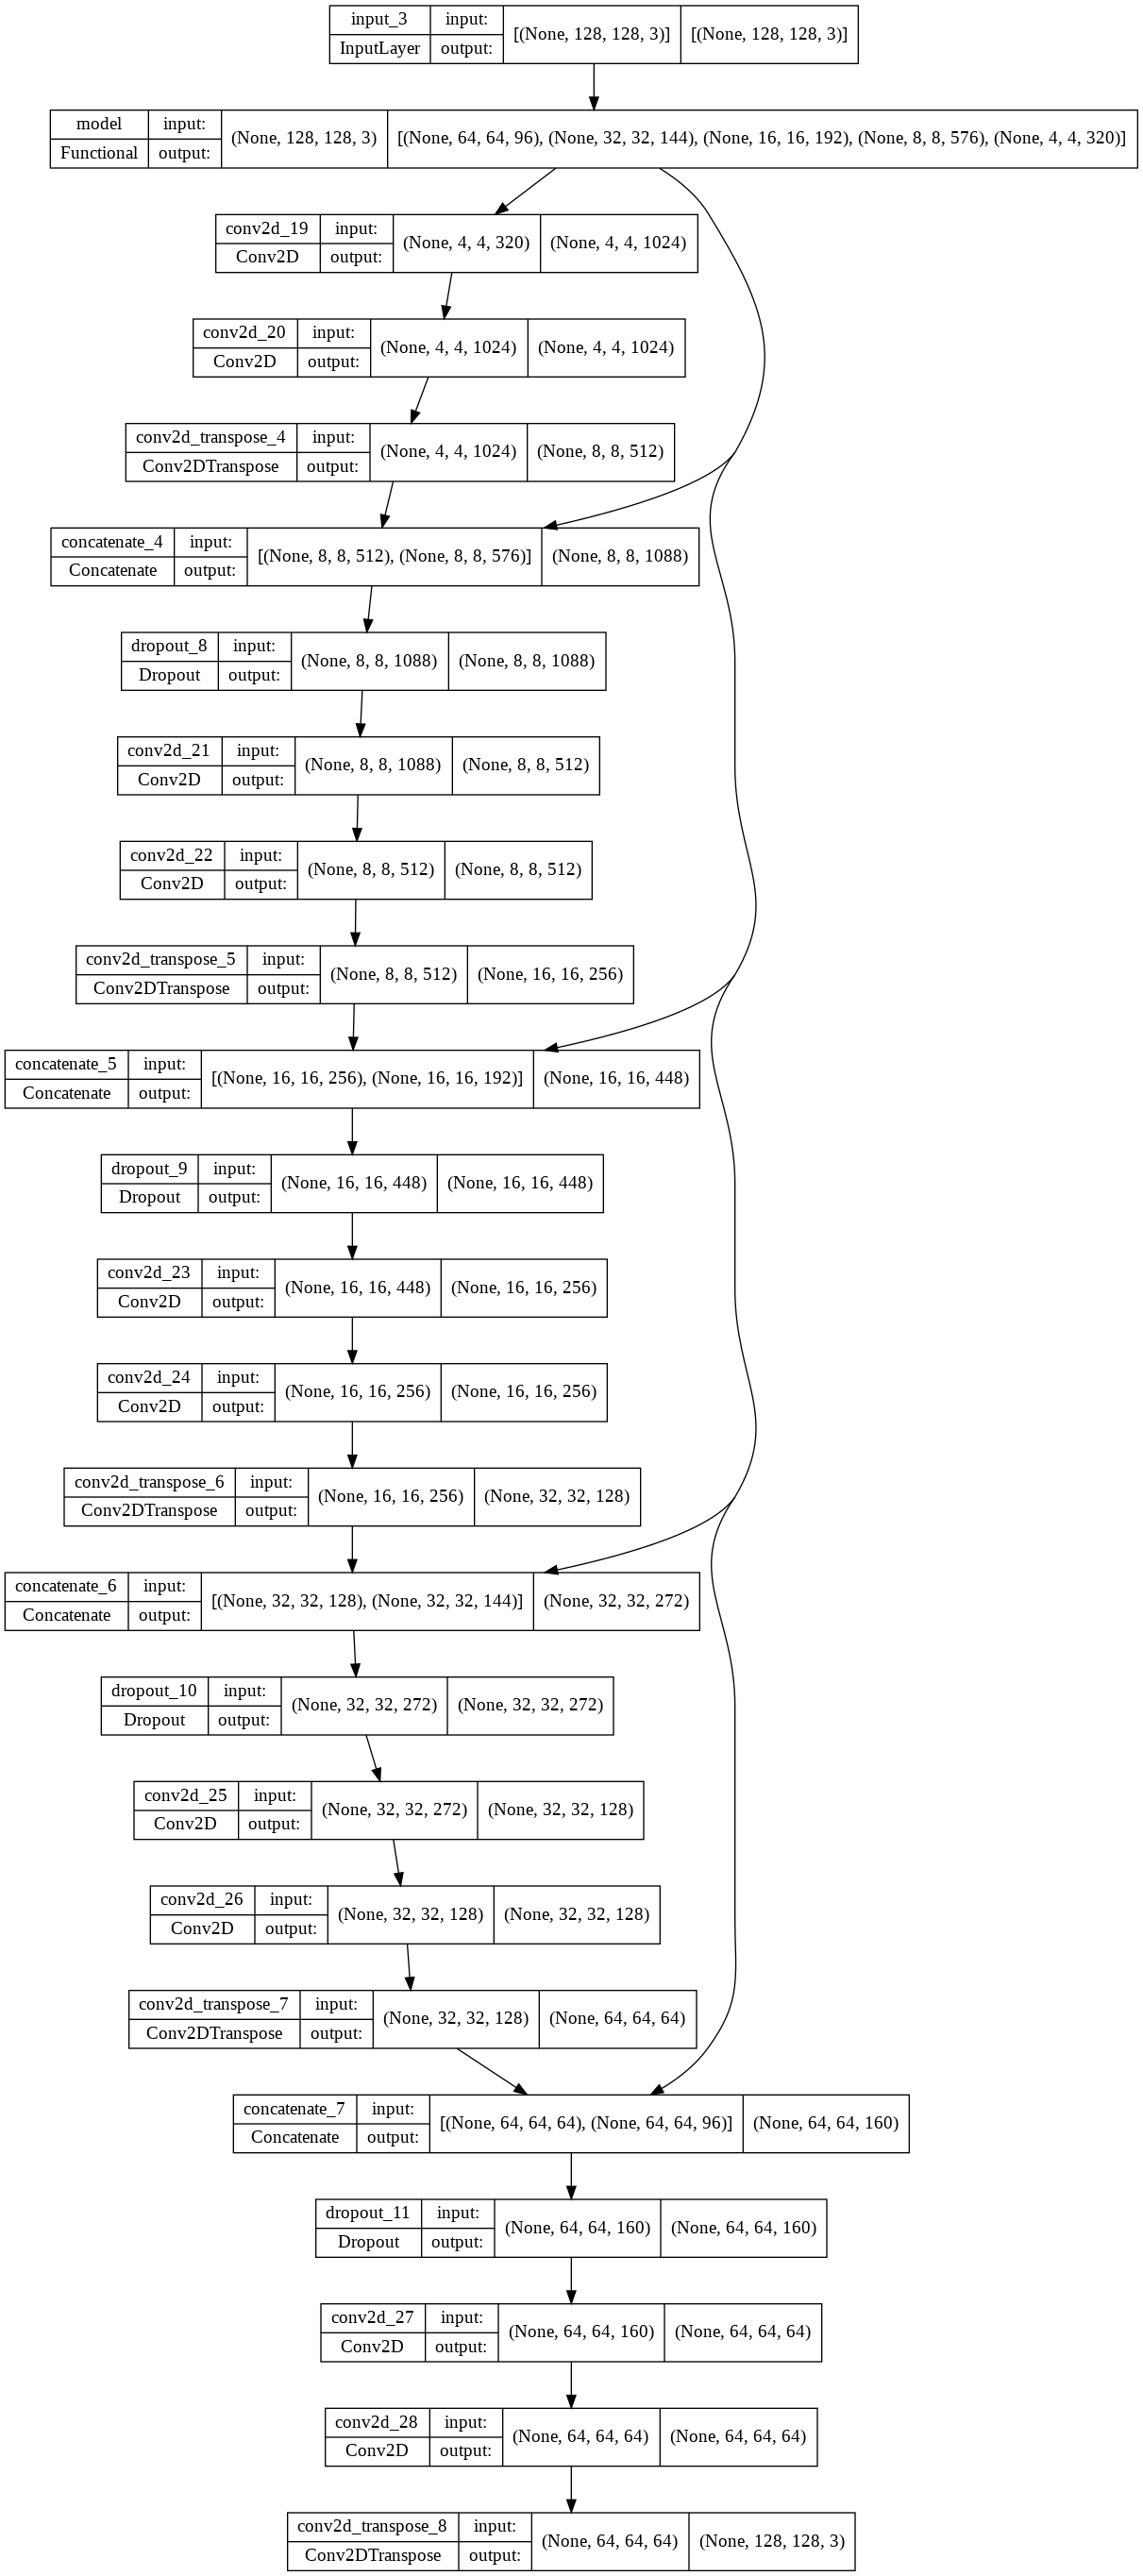

In [35]:
tf.keras.utils.plot_model(tl_unet_model, show_shapes=True)

In [36]:
tl_unet_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                   loss="sparse_categorical_crossentropy", 
                   metrics="accuracy")

In [37]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5

TEST_LENGTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

timeBegin = time.time()

model_history = tl_unet_model.fit(train_batches, 
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS, 
                               validation_data=validation_batches)

print("Total time processed {:.2f}".format(time.time()-timeBegin))

Epoch 1/20
57/57 [==============================] - 24s 278ms/step - loss: 0.7044 - accuracy: 0.7101 - val_loss: 0.4101 - val_accuracy: 0.8354
Epoch 2/20
57/57 [==============================] - 18s 267ms/step - loss: 0.3488 - accuracy: 0.8616 - val_loss: 0.3084 - val_accuracy: 0.8865
Epoch 3/20
57/57 [==============================] - 15s 263ms/step - loss: 0.2839 - accuracy: 0.8909 - val_loss: 0.3055 - val_accuracy: 0.8899
Epoch 4/20
57/57 [==============================] - 15s 262ms/step - loss: 0.2550 - accuracy: 0.9020 - val_loss: 0.2608 - val_accuracy: 0.9037
Epoch 5/20
57/57 [==============================] - 15s 259ms/step - loss: 0.2365 - accuracy: 0.9077 - val_loss: 0.2492 - val_accuracy: 0.9077
Epoch 6/20
57/57 [==============================] - 15s 260ms/step - loss: 0.2229 - accuracy: 0.9126 - val_loss: 0.2479 - val_accuracy: 0.9102
Epoch 7/20
57/57 [==============================] - 15s 263ms/step - loss: 0.2130 - accuracy: 0.9156 - val_loss: 0.3024 - val_accuracy: 0.8942

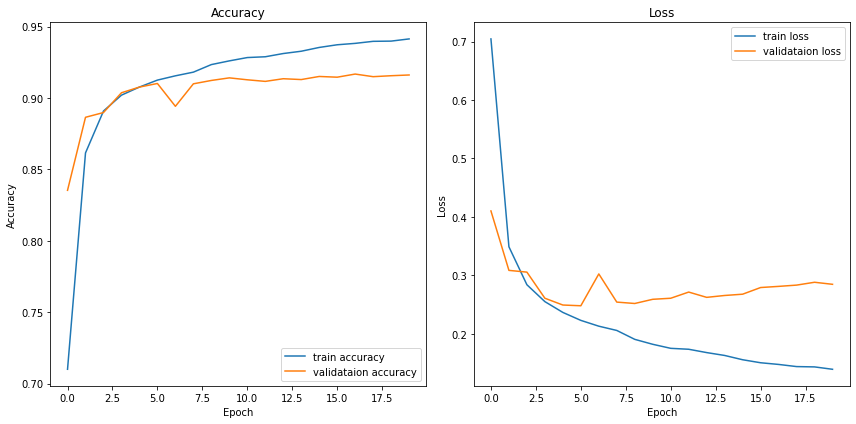

In [38]:
display_learning_curves(tl_unet_model.history)

In [39]:
count = 0
for i in test_batches:
  count += 1 
print("number of batches:", count)

number of batches: 11


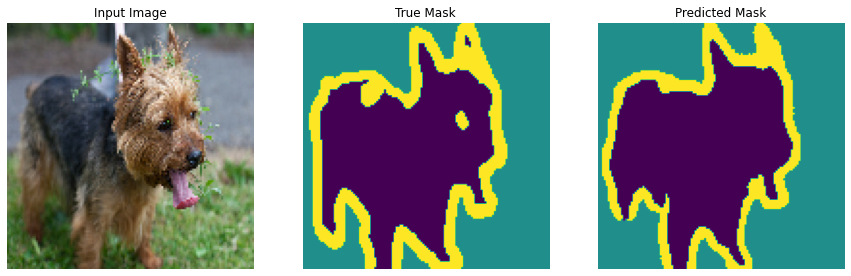

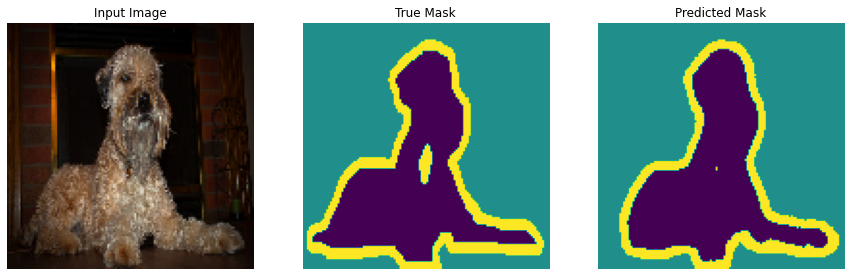

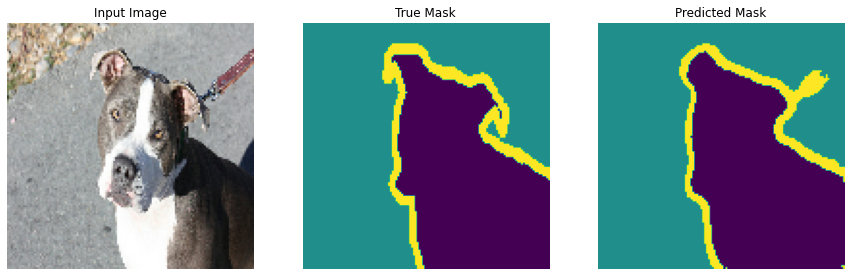

In [40]:
show_predictions(tl_unet_model, test_batches.skip(5), 3)